## Loan approval classifier
In this notebooks a XGBoost loan approval classifier for credit application is trained. Overview of this notebook: 
1. Load data
2. Explanatory data analysis
3. Split features, labels, train, validate and test set
4. Train XGBoost
5. Make prediction
6. Export predictions

To build this classifier an online tutorial was consulted: https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894.

### Load libraries and helper code

In [1]:
import sys
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# xgboost classifier
from xgboost import XGBClassifier

# initialize dataset
from helper_functions import *

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

### 1. Load data
Load one-hot encoded version of German Credit dataset.

In [2]:
gd = GermanDataset(
    
    # default pre-processing
    custom_preprocessing=default_preprocessing
)

Convert to pandas data frame.

In [3]:
df_gd = gd.convert_to_dataframe()[0]
df_gd.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,sex,status=A11,status=A12,...,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit
0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,42.0,7882.0,2.0,4.0,45.0,1.0,2.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,24.0,4870.0,3.0,4.0,53.0,2.0,2.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [4]:
df_gd.shape

(1000, 59)

### 2. Explanatory data analysis

Unbalanced dataset

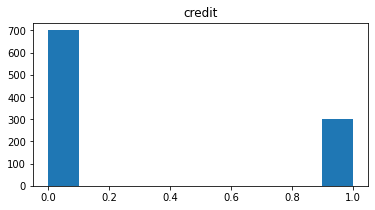

In [5]:
plt.figure(figsize=[6, 3])
plt.hist(df_gd["credit"])
plt.title("credit")
plt.show()

In [6]:
# create bins and labels
bins = [17,25,35,45,55,65,75]
labels = ["%s-%s" %(bins[idx-1]+1,bins[idx]) for idx in range(1,len(bins))]

# bin age colum
b = pd.cut(df_gd['age'], bins=bins, labels=labels, include_lowest=False)

# groupby age and credit column
df_grouped_age = df_gd.groupby(['credit', b]).size().unstack(fill_value=0).stack().reset_index(name='count')
df_grouped_age = df_grouped_age.groupby(['age','credit']).sum()
df_grouped_age

count
age   credit       
18-25 0.0       110
      1.0        80
26-35 0.0       280
      1.0       118
36-45 0.0       171
      1.0        55
46-55 0.0        87
      1.0        28
56-65 0.0        39
      1.0        14
66-75 0.0        13
      1.0         5

In [7]:
bin_default_dict = {}
bin_non_default_dict = {}

# iterate through age groups to compute default percentage
for label in labels:
    
    # number of defaulting applicants 
    n_default = df_grouped_age.loc[(label, 1.0)]['count']
    n_non_default = df_grouped_age.loc[(label, 0.0)]['count']
    
    # append to dictionary
    bin_default_dict["%s" %label] = str('{0:.0f}'.format((n_default/(n_default+n_non_default))*100)) + "%"
    bin_non_default_dict["%s" %label] = str('{0:.0f}'.format((n_non_default/(n_default+n_non_default))*100)) + "%"

bin_default_dict

{'18-25': '42%',
 '26-35': '30%',
 '36-45': '24%',
 '46-55': '24%',
 '56-65': '26%',
 '66-75': '28%'}

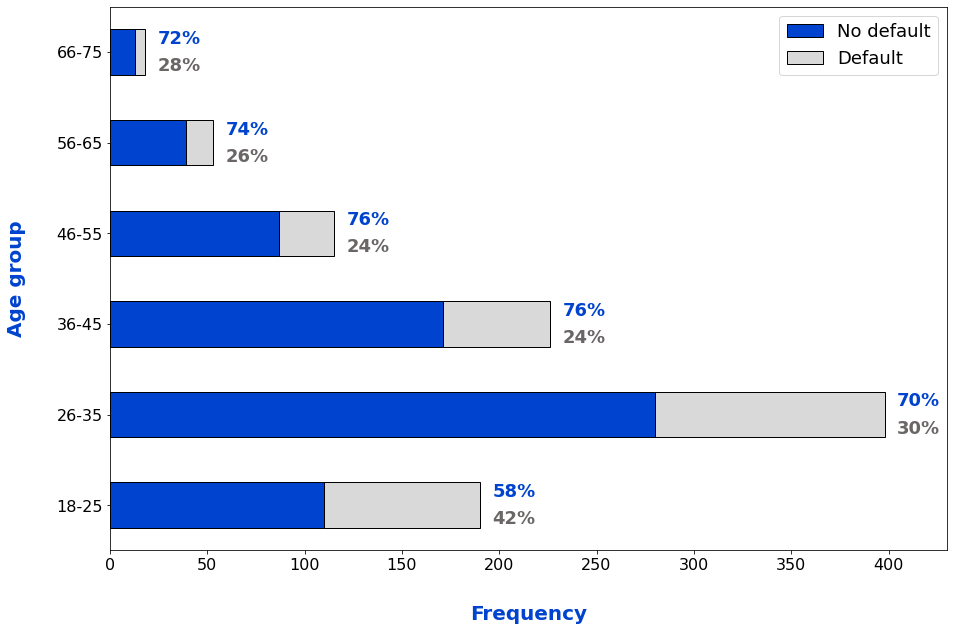

In [8]:
color_dark = "#0043CE"
color_light = "#D9D9D9"

# plot
fig, ax = plt.subplots(figsize=(15,10))
df_grouped_age.unstack().plot(kind='barh', stacked=True, ax=ax, color=[color_dark,color_light], edgecolor='k')

# x-axis
ax.set_xlabel("Frequency", fontsize=20, fontweight='bold', color=color_dark)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlim([0,430])
ax.xaxis.set_label_coords(0.5, -0.1)

# y-axis
ax.set_ylabel("Age group", fontsize=20, fontweight='bold', color=color_dark)
ax.yaxis.set_label_coords(-0.1, 0.5)

# iterate through labels to annotate text
for i in range(0,6):
    label = labels[i]
    x_coord = df_grouped_age.loc[label]['count'].sum()
    y_coord = i
    
    # annotate text
    plt.text(x_coord+17.5, y_coord+0.05, bin_non_default_dict[label], ha="center", va="bottom", color=color_dark, fontsize=18, fontweight="bold")
    plt.text(x_coord+17.5, y_coord-0.25, bin_default_dict[label], ha="center", va="bottom", color='#6B6666', fontsize=18, fontweight="bold")

# legend
ax.legend(['No default','Default'], fontsize=18)
    
plt.show()

In [9]:
# create bins and labels
bins = [0,1]
labels = [0.0]

# bin sex colum
b = pd.cut(df_gd['sex'], bins=bins, labels=labels, include_lowest=False)

# groupby sex and credit column
df_grouped_sex = df_gd.groupby(['credit', 'sex']).size().unstack(fill_value=0).stack().reset_index(name='count')
df_grouped_sex = df_grouped_sex.groupby(['sex','credit']).sum()
df_grouped_sex

count
sex credit       
0.0 0.0       499
    1.0       191
1.0 0.0       201
    1.0       109

In [10]:
bin_default_sex_dict = {}
bin_non_default_sex_dict = {}

labels = [0.0,1.0]

# iterate through age groups to compute default percentage
for label in labels:
    
    # number of defaulting applicants 
    n_default = df_grouped_sex.loc[(label, 1.0)]['count']
    n_non_default = df_grouped_sex.loc[(label, 0.0)]['count']
    
    # append to dictionary
    bin_default_sex_dict["%s" %label] = str('{0:.0f}'.format((n_default/(n_default+n_non_default))*100)) + "%"
    bin_non_default_sex_dict["%s" %label] = str('{0:.0f}'.format((n_non_default/(n_default+n_non_default))*100)) + "%"

bin_default_sex_dict

{'0.0': '28%', '1.0': '35%'}

In [11]:
bin_non_default_sex_dict

{'0.0': '72%', '1.0': '65%'}

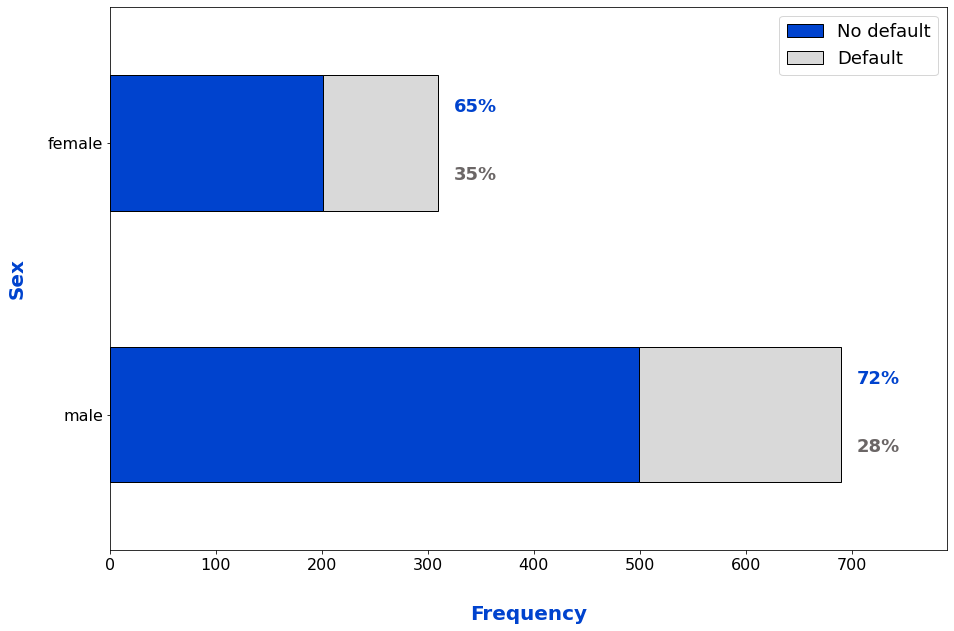

In [12]:
# plot
fig, ax = plt.subplots(figsize=(15,10))
df_grouped_sex.unstack().plot(kind='barh', stacked=True, ax=ax, color=[color_dark,color_light], edgecolor='k')

# x-axis
ax.set_xlabel("Frequency", fontsize=20, fontweight='bold', color=color_dark)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.set_xlim([0,790])

# y-axis
ax.set_ylabel("Sex", fontsize=20, fontweight='bold', color=color_dark)
ax.set_yticklabels(['male','female'])
ax.yaxis.set_label_coords(-0.1, 0.5)

# iterate through labels to annotate text
for i in range(0,2):
    label = labels[i]
    x_coord = df_grouped_sex.loc[label]['count'].sum()
    y_coord = i
    
    # annotate text
    plt.text(x_coord+35, y_coord+0.1, bin_non_default_sex_dict["%s" %label], ha="center", va="bottom", color=color_dark, fontsize=18, fontweight="bold")
    plt.text(x_coord+35, y_coord-0.15, bin_default_sex_dict["%s" %label], ha="center", va="bottom", color='#6B6666', fontsize=18, fontweight="bold")

# legend
ax.legend(['No default','Default'], fontsize=18)
    
plt.show()

### 3. Split features, labels, train, validate and test set

In [13]:
X = df_gd.drop('credit', axis=1)
y = df_gd['credit']

# Splitting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=10)

### 4. Train XGBoost

Initialize model and specify model parameters

In [14]:
xgbc = XGBClassifier()
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1) 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=None,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=1, nthread=None, num_parallel_tree=None, ...)

In [15]:
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### 5. Make predictions
Predict

In [16]:
y_hat = xgbc.predict(X_test)

Merging predictions to dataframe

In [17]:
# Converting y_hat from np to df
predictions_col = pd.DataFrame(index=X_test.index)
predictions_col['predicted_class'] = y_hat.tolist()
predictions_col['true_class'] = y_test.tolist()

# Calculating the errors with the absolute value 
predictions_col['errors'] = abs(predictions_col['predicted_class'] - predictions_col['true_class'])

# Adding predictions to test data
entire_dataset = pd.merge(X_test, predictions_col, left_index = True, right_index = True)
entire_dataset.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,sex,status=A11,status=A12,...,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,predicted_class,true_class,errors
841,21.0,2993.0,3.0,2.0,28.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0
956,30.0,3656.0,4.0,4.0,49.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0
544,12.0,1255.0,4.0,4.0,61.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0
173,8.0,1414.0,4.0,2.0,33.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0
759,12.0,691.0,4.0,3.0,35.0,2.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,1.0,1.0


#### Confusion matrix

Acc:  0.7366666666666667


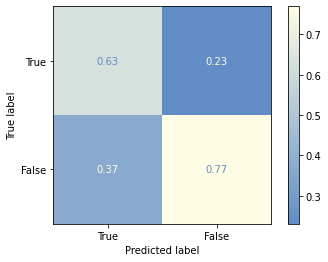

In [18]:
predictions = entire_dataset["predicted_class"]
true = entire_dataset["true_class"]

cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')
cmap0 = mpl.colors.LinearSegmentedColormap.from_list(
        'unevently divided', ['#618EC7','#fffde4'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['True', 'False'])
disp.plot(cmap=cmap0)

print('Acc: ', accuracy_score(predictions,true))

### 6. Export data

In [19]:
entire_dataset.to_csv('./pred_XGBoost.csv', index=False)